In [1]:
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import sklearn.metrics as skm
import os
from sklearn.model_selection import train_test_split

2023-06-29 17:26:04.446575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the datasets

# data_path = '/gpfswork/rech/prk/uzk69cg/psf_dataset2/'
data_path = '/Users/as274094/Documents/psf_dataset2/'
test_dataset = np.load(data_path + 'test_Euclid_res_20000_TestStars_id_002GT_100_bins.npy', allow_pickle=True)[()]
train_dataset = np.load(data_path + 'train_Euclid_res_52000_TrainStars_id_002GT_100_bins.npy', allow_pickle=True)[()]

In [17]:
def calculate_success_rate(confusion_matrix):
    diagonal = np.trace(confusion_matrix)
    diagonal_neighbors = np.sum(np.diagonal(confusion_matrix, offset=1)) + np.sum(np.diagonal(confusion_matrix, offset=-1))
    total_classified = np.sum(confusion_matrix)
    
    success_rate = (diagonal + diagonal_neighbors) / total_classified
    return success_rate

class TrainingCompletionCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        epochs = len(self.model.history.history['loss'])
        final_loss = self.model.history.history['loss'][-1]
        final_val_loss = self.model.history.history['val_loss'][-1]
        final_acc = self.model.history.history['categorical_accuracy'][-1]
        final_val_acc = self.model.history.history['val_categorical_accuracy'][-1]

        print("Training completed. Number of epochs:", epochs, ", Final training loss:", final_loss, ", Final validation loss:", final_val_loss)
        print("Final accuracy:", final_acc, "Final validation accuracy:", final_val_acc)

completion_callback = TrainingCompletionCallback()

initializer = tf.keras.initializers.GlorotNormal(seed = 25)

star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

class CNN_model:
    def __init__(self, train_dataset, test_dataset, architecture):
        train_stars = np.expand_dims(train_dataset['noisy_stars'], axis = 3)
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(train_stars,
                                                                               train_dataset['SED_ids'],test_size = 20000, shuffle = False) # Reserve 20,000 stars for validation
        self.x_test = np.expand_dims(test_dataset['noisy_stars'], axis = 3)
        self.y_test = test_dataset['SED_ids']
        self.y_train_cat = tf.keras.utils.to_categorical(self.y_train,num_classes = 13)
        self.y_val_cat = tf.keras.utils.to_categorical(self.y_val,num_classes = 13)
        self.y_test_cat = tf.keras.utils.to_categorical(self.y_test,num_classes = 13)
        self.learning = []
        self.model = architecture
        
    
    def train_model(self, learning_rate, training_epochs, patience_epochs):

        self.model.compile(
            loss = 'categorical_crossentropy',
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
            metrics = 'categorical_accuracy'
        )
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = patience_epochs, restore_best_weights=True)

        learn = self.model.fit(self.x_train, self.y_train_cat, epochs= training_epochs, verbose = 0,
                                        callbacks = [completion_callback,early_stopping], validation_data=(self.x_val,self.y_val_cat), shuffle=True) 

        self.learning.append(learn)

    def predict_test(self, verbose = True):
        y_test_pred = self.model.predict(self.x_test)
        class_predictions = np.argmax(y_test_pred, axis = 1)

        self.f1_test = skm.f1_score(self.y_test, class_predictions, average = None)
        self.f1_mean_test = np.mean(self.f1_test[:13])
        self.confusion_matrix_test = skm.confusion_matrix(self.y_test, class_predictions)
        self.success_rate_test = calculate_success_rate(self.confusion_matrix_test)

        if(verbose):
            print("Prediction results for the test set")
            print('Average F1 score:', self.f1_mean_test)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_test)
            print('\nSuccess rate:', self.success_rate_test)


    def predict_val(self, verbose = True):
        y_val_pred = self.model.predict(self.x_val)
        class_predictions = np.argmax(y_val_pred, axis = 1)

        self.f1_val = skm.f1_score(self.y_val, class_predictions, average = None)
        self.f1_mean_val = np.mean(self.f1_val[:13])
        self.confusion_matrix_val = skm.confusion_matrix(self.y_val, class_predictions)
        self.success_rate_val = calculate_success_rate(self.confusion_matrix_val)

        if(verbose):
            print("Prediction results for the validation set")
            print('Average F1 score:', self.f1_mean_val)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_val)
            print('\nSuccess rate:', self.success_rate_val)

    def save_model(self, N_model = 1):

        self.model.save(f"saved_models/{self.dataset_name}/my_model_{N_model}.h5")

    def load_model(self, N_model = 1):
        self.model = tf.keras.models.load_model(f"saved_models/{self.configuration['config_name']}/{self.dataset_name}/my_model_{N_model}.h5")
        

    def plot_training_evolution(self):
    # Plot the loss function and accuracy evolution

        loss_evolution = self.learning[-1].history["loss"]
        val_loss_evolution = self.learning[-1].history["val_loss"]
        acc_evolution = self.learning[-1].history['categorical_accuracy']
        val_acc_evolution = self.learning[-1].history['val_categorical_accuracy']

        plt.figure(figsize = (9,5))
        plt.subplot(121)
        plt.plot(loss_evolution,label = "Train set")
        plt.plot(val_loss_evolution,label = "Validation set")
        plt.xlabel("Epochs")
        plt.ylabel("Loss function value")
        plt.legend()
        plt.title("Loss function evolution")

        plt.subplot(122)
        plt.plot(acc_evolution)
        plt.plot(acc_evolution,label = "Train set")
        plt.plot(val_acc_evolution,label = "Validation set")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Categorical accuracy evolution")

        print("Training loss:", loss_evolution[-1], ", Validation loss:", val_loss_evolution[-1])
        print("Training accuracy:", acc_evolution[-1], ", Validation accuracy:", val_acc_evolution[-1])

    def plot_cf_matrix(self):
        # Plot the confusion matrix

        plt.figure(figsize= (12,10))
        heatmap = plt.imshow(self.confusion_matrix_test[:13,:], cmap='Blues')
        plt.xticks(np.arange(13), star_class_labels)
        plt.yticks(np.arange(13), star_class_labels)
        plt.colorbar(heatmap)
        plt.xlabel("Estimated spectral type")
        plt.ylabel("True spectral type")
        plt.show()

    def plot_metrics(self):
        # Plot the metrics

        plt.figure(figsize = (9,5))
        plt.bar(np.arange(13), height = self.f1_test[:13], tick_label = star_class_labels ,label = "F1 score")
        plt.axhline(self.f1_mean_test, color='red', linestyle='--', label = 'F1 score average')
        plt.axhline(self.success_rate_test, color='purple', label = 'Success rate')
        plt.xlabel("Spectral class")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()

In [18]:
architecture = tf.keras.Sequential([
    layers.Conv2D(5, kernel_size = 5, activation = 'relu', input_shape = (32,32,1)),
    layers.MaxPooling2D(2),
    layers.Conv2D(5, kernel_size = 5, activation = 'relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(10, activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(10, activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(13, activation = 'softmax'),
])
architecture.summary()

model3 = CNN_model(train_dataset, test_dataset, architecture)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 5)         130       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 5)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 5)         630       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 5)          0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 125)               0         
                                                                 
 dense_9 (Dense)             (None, 10)               

In [20]:

model3.train_model(training_epochs= 100, learning_rate= 0.001, patience_epochs= 10)
model3.predict_val()
model3.predict_test()

Training completed. Number of epochs: 38 , Final training loss: 1.3327178955078125 , Final validation loss: 1.9679855108261108
Final accuracy: 0.43031251430511475 Final validation accuracy: 0.3122999966144562
625/625 [==============================] - 3s 4ms/step
Prediction results for the validation set
Average F1 score: 0.449321595306581

Confusion matrix:
[[ 932  475   79    9   13    2    0    0    0    0    0    0    0]
 [ 710  646  125   34   13    0    0    0    0    0    0    0    0]
 [  38  354  520  275  254   48    4    1    0    0    0    0    0]
 [   3  131  416  345  503  126    9    4    0    1    0    0    0]
 [   0   12   76  144  647  613   82   12    1    3    0    0    0]
 [   0    0    6   14  118  691  518  128    8   17    2    0    0]
 [   0    0    0    0   30  284  612  505   33  107    9    0    0]
 [   0    0    0    0    5   27  147  522   91  687   89    0    0]
 [   0    0    0    0    0   20   75  284   53  892  191    1    0]
 [   0    0    0    0    0 

Training loss: 1.3327178955078125 , Validation loss: 1.9679855108261108
Training accuracy: 0.43031251430511475 , Validation accuracy: 0.3122999966144562


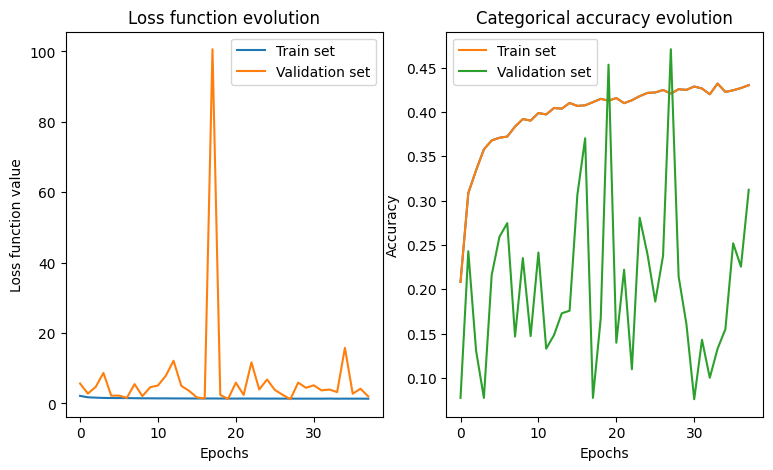

In [21]:
model3.plot_training_evolution()